# NCP, Fe uptake, lims,Fe timeseries from the CESM-LE

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
CPU times: user 163 ms, sys: 16.2 ms, total: 179 ms
Wall time: 608 ms


In [3]:
ds['mesozooC'] = ds.zooC_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))

### get pop grid

In [4]:
grid = pop_tools.get_grid('POP_gx1v6')

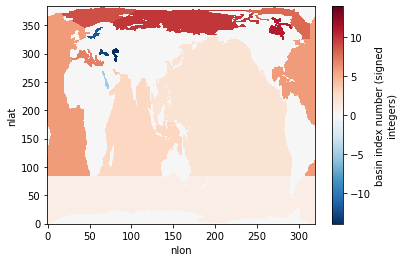

In [5]:
grid.REGION_MASK.plot()

In [6]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [7]:
ds = ds.where(grid.REGION_MASK>0)

### get masks for making averages

In [8]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### Make timeseries

In [11]:
variables = variables + ['mesozooC']

### ACC

In [12]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()


CPU times: user 32.2 s, sys: 45 s, total: 1min 17s
Wall time: 1min 28s


### SIZ

In [13]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    print(v)
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

diatC_zint100m
spC_zint100m
zooC_zint100m
mesozooC
CPU times: user 32 s, sys: 45 s, total: 1min 17s
Wall time: 1min 27s


In [14]:
ts_ACC_ens_mean = ts_ACC.mean(dim='member_id')
ts_SIZ_ens_mean = ts_SIZ.mean(dim='member_id')

In [15]:
ts_ACC_ens_mean['mesozooC']

<xarray.DataArray 'mesozooC' (time: 181)>
array([31.36503905, 32.68486162, 32.87015009, 32.85549429, 32.84551938,
       32.34822302, 32.66906242, 32.38302618, 32.60727363, 32.67425703,
       32.52450654, 32.74000375, 32.85495786, 33.02148797, 32.81174274,
       32.64280833, 32.73559453, 33.20096457, 33.03305337, 32.73931152,
       32.76073274, 32.00378597, 32.02398521, 32.6765775 , 32.4239445 ,
       32.79687129, 32.84573498, 33.19773536, 32.29344959, 32.86965713,
       33.35100554, 33.03529624, 32.81272441, 32.98946403, 33.13434583,
       33.08971083, 33.4418711 , 33.41517386, 33.39188456, 32.78476458,
       32.88359381, 32.86831686, 33.30756967, 33.2059269 , 33.36647567,
       32.83679287, 33.05058669, 33.38710793, 32.93254936, 32.66450604,
       33.14223141, 33.04461258, 33.13806221, 33.52439119, 33.60824592,
       33.1210184 , 33.00345355, 33.19294152, 33.03512991, 33.30987494,
       33.29360321, 33.2392068 , 33.10206506, 33.97102331, 33.44701812,
       33.15618004, 33.7901783 , 33.94708508, 34.09623849, 33.76799484,
       33.92454061, 34.09563575, 33.72966829, 33.49097374, 33.50345612,
       33.8299956 , 34.05788005, 34.15417221, 34.13923569, 34.1910037 ,
       34.43818688, 34.32597939, 34.35029364, 34.36894081, 34.8721568 ,
       34.79709107, 34.25016325, 34.49323522, 34.19056987, 34.24849227,
       34.29316523, 34.93526755, 34.58927573, 34.69893723, 34.77921536,
       34.93083708, 35.08244099, 34.74396161, 34.81164857, 34.77846363,
       34.76794842, 34.80090199, 34.95283852, 35.13457528, 35.03068717,
       34.90633814, 35.06588515, 35.02822866, 35.14357472, 35.30720691,
       35.26184554, 35.20883909, 35.19699259, 35.34842431, 35.07433757,
       35.14690254, 35.49913154, 35.63598366, 35.26692358, 35.29478927,
       35.73333773, 35.60725945, 35.91855059, 35.97235336, 35.89140144,
       35.77502805, 35.72683255, 35.75675124, 35.9654649 , 35.50782178,
       36.12734455, 36.05226319, 35.98885276, 36.06165216, 35.94716243,
       36.14029362, 36.34184172, 36.39859445, 35.99061195, 36.24000821,
       36.32440704, 36.33276383, 35.99117565, 36.59583178, 36.17815313,
       36.39397154, 36.28619333, 36.27692634, 36.53401939, 36.39540598,
       36.53550525, 36.66968544, 36.82631604, 36.62218295, 36.58684316,
       36.4410312 , 36.73700731, 36.83542528, 36.49066381, 36.5015516 ,
       36.51678488, 36.71492313, 36.66068123, 36.68735931, 36.66701404,
       36.75361568, 36.63848243, 36.8290377 , 36.80857821, 36.92179903,
       37.28571375, 36.96359119, 36.85901401, 36.82478587, 36.77524295,
       36.77453805, 36.98797425, 36.88372639, 36.93596581, 37.04950958,
       37.13962628])
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Attributes:
    long_name:     100 m depth-integrated zooplankton carbon
    units:         mmol m-2
    grid_loc:      3114
    cell_methods:  time: mean

In [16]:
ts_ACC

<xarray.Dataset>
Dimensions:         (member_id: 34, time: 181)
Coordinates:
  * time            (time) int64 1920 1921 1922 1923 ... 2097 2098 2099 2100
  * member_id       (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
Data variables:
    diatC_zint100m  (time, member_id) float64 52.83 53.11 56.04 ... 66.59 61.16
    spC_zint100m    (time, member_id) float64 63.72 67.55 69.19 ... 50.03 48.87
    zooC_zint100m   (time, member_id) float64 74.29 76.59 76.51 ... 72.36 70.55
    mesozooC        (time, member_id) float64 31.8 31.92 31.68 ... 37.92 36.57

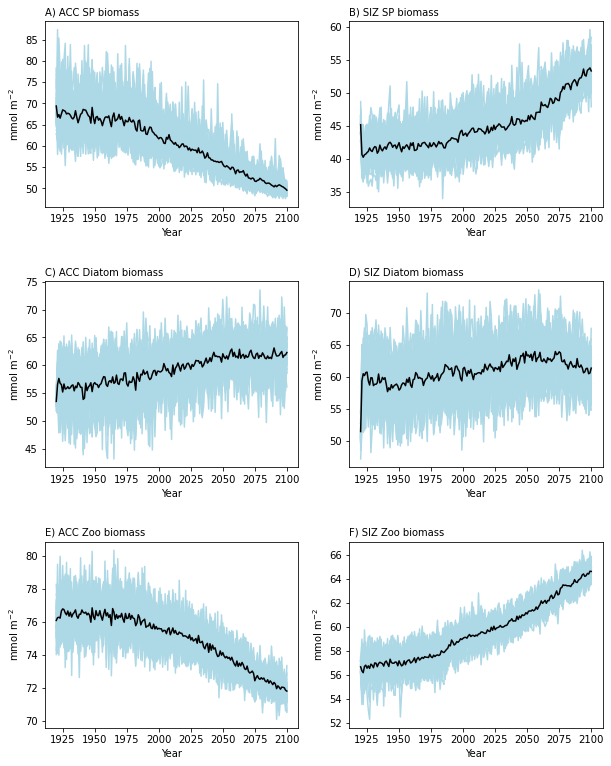

In [32]:
fig = plt.figure(figsize=(10,13))

############## spC

ax1 = fig.add_subplot(3,2,1)
ax1.set_title('A) ACC SP biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):
    ax1.plot(years, 
         ts_ACC['spC_zint100m'].isel(member_id=mem), 
         color='lightblue')
ax1.plot(years, ts_ACC_ens_mean['spC_zint100m'], 
         color='black')


ax1 = fig.add_subplot(3,2,2)
ax1.set_title('B) SIZ SP biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax1.plot(years, 
         ts_SIZ['spC_zint100m'].isel(member_id=mem), 
         color='lightblue')

ax1.plot(years, ts_SIZ_ens_mean['spC_zint100m'], 
         color='black')


############## diatC

ax1 = fig.add_subplot(3,2,3)
ax1.set_title('C) ACC Diatom biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):
    ax1.plot(years, 
         ts_ACC['diatC_zint100m'].isel(member_id=mem), 
         color='lightblue')
ax1.plot(years, ts_ACC_ens_mean['diatC_zint100m'], 
         color='black')


ax1 = fig.add_subplot(3,2,4)
ax1.set_title('D) SIZ Diatom biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax1.plot(years, 
         ts_SIZ['diatC_zint100m'].isel(member_id=mem), 
         color='lightblue')

ax1.plot(years, ts_SIZ_ens_mean['diatC_zint100m'], 
         color='black')


############## zooC

ax1 = fig.add_subplot(3,2,5)
ax1.set_title('E) ACC Zoo biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):
    ax1.plot(years, 
         ts_ACC['zooC_zint100m'].isel(member_id=mem), 
         color='lightblue')
ax1.plot(years, ts_ACC_ens_mean['zooC_zint100m'], 
         color='black')


ax1 = fig.add_subplot(3,2,6)
ax1.set_title('F) SIZ Zoo biomass',fontsize=10, loc='left')
ax1.set_ylabel('mmol m$^{-2}$')
ax1.set_xlabel('Year')
#ax1.set_ylim(1.4,2.05)
for mem in np.arange(0,34,1):

    ax1.plot(years, 
         ts_SIZ['zooC_zint100m'].isel(member_id=mem), 
         color='lightblue')

ax1.plot(years, ts_SIZ_ens_mean['zooC_zint100m'], 
         color='black')


# ############## mesozooC

# ax1 = fig.add_subplot(4,2,7)
# ax1.set_title('G) ACC Mesozoo biomass',fontsize=10, loc='left')
# ax1.set_ylabel('mmol m$^{-2}$')
# ax1.set_xlabel('Year')
# #ax1.set_ylim(1.4,2.05)
# for mem in np.arange(0,34,1):
#     ax1.plot(years, 
#          ts_ACC['mesozooC'].isel(member_id=mem), 
#          color='lightblue')
# ax1.plot(years, ts_ACC_ens_mean['mesozooC'], 
#          color='black')


# ax1 = fig.add_subplot(4,2,8)
# ax1.set_title('H) SIZ Diatom biomass',fontsize=10, loc='left')
# ax1.set_ylabel('mmol m$^{-2}$')
# ax1.set_xlabel('Year')
# #ax1.set_ylim(1.4,2.05)
# for mem in np.arange(0,34,1):

#     ax1.plot(years, 
#          ts_SIZ['mesozooC'].isel(member_id=mem), 
#          color='lightblue')

# ax1.plot(years, ts_SIZ_ens_mean['mesozooC'], 
#          color='black')
fig.subplots_adjust(hspace=0.4)
fig.savefig('/glade/work/kristenk/figs/biomass_line_plots.png', bbox_inches='tight', dpi=300, format='png');